# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

#### Attribute Information

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Business Objective
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be considered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


#### Remark

Part of this notebook was kindly provided from professors at: https://www.appliedaicourse.com

# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, I'm using the SQLITE dataset as it is easier to query the data and visualize the data efficiently.

Here as I only want to get the global sentiment of the recommendations (positive or negative), I will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set as "negative".

In [739]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [740]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 150000""", con) 

# sample x data-points
filtered_data = filtered_data.sample(100000)

# sort for timebased splitting
filtered_data = filtered_data.sort_values(by=['Time'])

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...


In [741]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [742]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence, it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.

In [745]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Therefore, in order to reduce redundancy, it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [746]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [747]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(88000, 10)

In [748]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

88.0

<b>Observation:</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [749]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [750]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [751]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(88000, 10)


1    74119
0    13881
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [755]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [759]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

In [761]:
preprocessed_reviews[1500]

'bought brand coconut oil strictly beauty bodily purposes works quite well overall face body moisturizer although use primarily lip treatment cold dry winter months still solid form due cold weather area taking small chunks allowing melt hands seconds applying skin others users noted found oil toasty like smell not mind much might try nutiva brand next time heard nicer smell near future probably purchase coconut oils cooking baking purposes give brand'

#  [4] Featurization & Modeling

In [766]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import model_selection
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV
from prettytable import PrettyTable
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt

In [767]:
alphas = [.0001, .001, .01, .1, 1, 10, 100, 1000, 10000]

# define gridsearch strategy
gs = GridSearchCV(MultinomialNB(), 
                  param_grid={'alpha': alphas},
                  scoring='roc_auc', cv=10, refit=True, return_train_score=True)

# table to store all the models' auc
models_auc = PrettyTable()
models_auc.field_names = ["Vectorizer", "Hyper paramter", "AUC"]

##### the SAMPLING and TIME SORTING was made in the first cell (392) #####
y = final.Score.values

X = np.array(preprocessed_reviews)

# split non-vectorized data into training and test
X_tr, X_test, y_tr, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)

# get length of each review for Feature Engineering
X_tr_len = np.array([len(i) for i in X_tr])
X_tr_len = X_tr_len[:, np.newaxis]

X_test_len = np.array([len(i) for i in X_test])
X_test_len = X_test_len[:, np.newaxis]

In [768]:
# some auxiliary functions to reduce repetition

# plot hyperparameters vs auc
def plot_hp_auc():
    print('Best hyperparameter {}'.format(gs.best_params_.get('alpha')))

    # here I'm using the mean scores from train & test 
    hyper_parameters = np.array(gs.cv_results_.get('param_alpha'))
    tr_scores = gs.cv_results_.get('mean_train_score')
    cv_scores = gs.cv_results_.get('mean_test_score')
    
    plt.title('CV vs Training - AUC')

    plt.ylabel("AUC")
    plt.xlabel('Hyper paramters')

    plt.plot(hyper_parameters, tr_scores, 'r', label='Train AUC')
    plt.plot(hyper_parameters, cv_scores, 'b', label='CV AUC')

    plt.grid()
    plt.legend()
    plt.show()
    
def plot_auroc(y_tr, predictions_tr, y_test, predictions_test):
    # compute fpr, tpr and auc for TRAINING set
    fpr_tr, tpr_tr, _ = roc_curve(y_tr, predictions_tr)
    roc_auc_tr = auc(fpr_tr, tpr_tr)

    # compute fpr, tpr and auc for TEST set
    fpr_test, tpr_test, _ = roc_curve(y_test, predictions_test)
    roc_auc_test = auc(fpr_test, tpr_test)

    plt.title('AUROC')

    plt.ylabel("True Positive Rate")
    plt.xlabel('False Positive Rate')

    plt.plot(fpr_tr, fpr_tr, 'k--')
    plt.plot(fpr_tr, tpr_tr, 'r', label='Training - AUC: {}'.format(round(roc_auc_tr, 3)))
    plt.plot(fpr_test, tpr_test, 'b', label='Test - AUC: {}'.format(round(roc_auc_test, 3)))

    plt.grid()
    plt.legend()
    plt.show()
    
def print_confusion_matrix(X_test, y_test):
    # predicts without probability score on TEST dataset
    predictions_test = gs.predict(X_test)

    # compute confusion matrix
    cf_matrix = confusion_matrix(y_test, predictions_test)
 
    tn, fp, fn, tp = cf_matrix.ravel()
    print('True Negatives = {}'.format(tn))
    print('False Positives = {}'.format(fp))
    print('False Negatives = {}'.format(fn))
    print('True Positives = {}'.format(tp))
    
    heatmap = sns.heatmap(cf_matrix, annot=True, fmt="d")
    
    plt.show()

## [4.1] Applying Multinomial Naive Bayes on BOW,<font color='red'> SET 1</font>

In [769]:
# BoW bigrams
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10)

# training
bow_X_tr = count_vect.fit_transform(X_tr)
# add column with size of reviews (feature engineering)
bow_X_tr = hstack((bow_X_tr, X_tr_len))

# test
bow_X_test = count_vect.transform(X_test)
# add column with size of reviews (feature engineering)
bow_X_test = hstack((bow_X_test, X_test_len))

print(bow_X_tr.shape)
print(bow_X_test.shape)

(61600, 36525)
(26400, 36525)


In [770]:
# should be (4750, 3087)

In [771]:
# find optimal K
gs.fit(bow_X_tr, y_tr)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [772]:
# make predictions on TRAINING dataset with optimal K
predictions_tr = gs.predict_proba(bow_X_tr)[:, 1]
# get AUC score for TRAINING set
roc_auc_tr = roc_auc_score(y_tr, predictions_tr)

# make predictions on TEST dataset with optimal K
predictions_test = gs.predict_proba(bow_X_test)[:, 1]
# get AUC score for TEST set
roc_auc_test = roc_auc_score(y_test, predictions_test)

models_auc.add_row(['BOW', gs.best_params_.get('alpha'), roc_auc_test])

Best hyperparameter 1


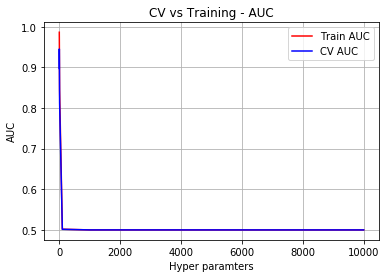

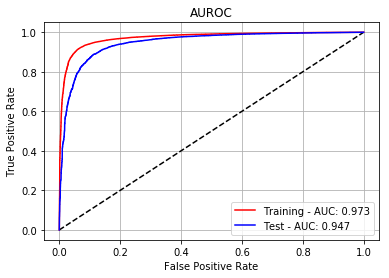

True Negatives = 3342
False Positives = 837
False Negatives = 1330
True Positives = 20891


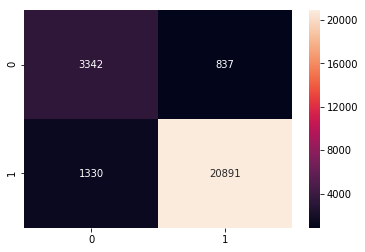

In [773]:
plot_hp_auc()
plot_auroc(y_tr, predictions_tr, y_test, predictions_test)
print_confusion_matrix(bow_X_test, y_test)

In [774]:
# create data frame with coef and feature names
feat_coef = np.abs(gs.best_estimator_.coef_.T)
feat_names = np.array(count_vect.get_feature_names())
feat_names = np.append(feat_names, 'review_length')

df = pd.DataFrame(feat_coef, columns=['coef'])
df['names'] = feat_names

# sort in descending order
df.sort_values(by='coef', inplace=True, ascending=False)                      

### [4.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [775]:
print(df.tail(10))

           coef          names
11200  7.120872         flavor
18305  7.115374           love
31402  7.018762          taste
5633   6.976706         coffee
22491  6.933340            one
14011  6.804274          great
13419  6.738646           good
17191  6.598753           like
21300  5.769561            not
36524  0.186560  review_length


### [4.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [776]:
print(df.head(10))

            coef                   names
36015  16.569993            worst coffee
31710  16.569993              tasted old
32271  16.569993        terrible product
32708  16.569993              threw rest
13386  16.569993             going trash
12586  16.569993             garbage not
26691  16.569993               refunding
10217  16.569993  extremely disappointed
26688  16.569993              refund not
15415  16.569993     huge disappointment


## [4.2] Applying Multinomial Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [777]:
# tf-idf bigrams
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)

# training
tf_idf_X_tr = tf_idf_vect.fit_transform(X_tr)
# add column with size of reviews (feature engineering)
tf_idf_X_tr = hstack((tf_idf_X_tr, X_tr_len))

# test
tf_idf_X_test = tf_idf_vect.transform(X_test)
# add column with size of reviews (feature engineering)
tf_idf_X_test = hstack((tf_idf_X_test, X_test_len))

In [778]:
# find optimal K
gs.fit(tf_idf_X_tr, y_tr)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [779]:
# make predictions on TRAINING dataset with optimal K
predictions_tr = gs.predict_proba(tf_idf_X_tr)[:, 1]
# get AUC score for TRAINING set
roc_auc_tr = roc_auc_score(y_tr, predictions_tr)

# make predictions on TEST dataset with optimal K
predictions_test = gs.predict_proba(tf_idf_X_test)[:, 1]
# get AUC score for TEST set
roc_auc_test = roc_auc_score(y_test, predictions_test)

models_auc.add_row(['TF-IDF', gs.best_params_.get('alpha'), roc_auc_test])

Best hyperparameter 0.1


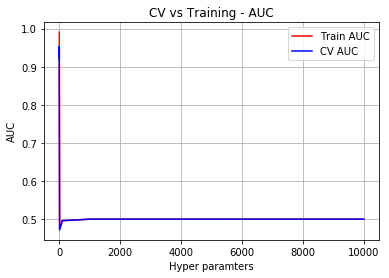

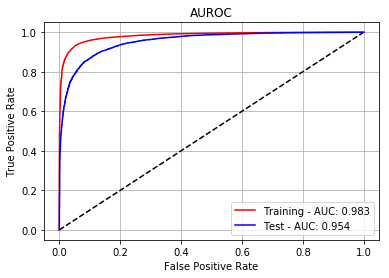

True Negatives = 2040
False Positives = 2139
False Negatives = 266
True Positives = 21955


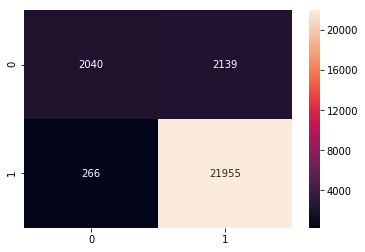

In [780]:
plot_hp_auc()
plot_auroc(y_tr, predictions_tr, y_test, predictions_test)
print_confusion_matrix(tf_idf_X_test, y_test)

In [781]:
# create data frame with coef and feature names
feat_coef = np.abs(gs.best_estimator_.coef_.T)
feat_names = np.array(count_vect.get_feature_names())
feat_names = np.append(feat_names, 'review_length')

df = pd.DataFrame(feat_coef, columns=['coef'])
df['names'] = feat_names

# sort in descending order
df.sort_values(by='coef', inplace=True, ascending=False)

### [4.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [782]:
print(df.tail(10))

           coef          names
22491  9.790046            one
25114  9.776321        product
31879  9.691048            tea
18305  9.664284           love
17191  9.559782           like
5633   9.552185         coffee
13419  9.512526           good
14011  9.444375          great
21300  9.085226            not
36524  0.022945  review_length


### [4.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [783]:
print(df.head(10))

            coef                 names
18910  18.708964  major disappointment
13386  18.708964           going trash
36015  18.708964          worst coffee
15415  18.708964   huge disappointment
13198  18.708964       glowing reviews
31710  18.708964            tasted old
12586  18.708964           garbage not
36494  18.708964             zero star
35493  18.708964            went trash
32708  18.708964            threw rest


# [5] Results summary

In [784]:
print(models_auc)

+------------+----------------+--------------------+
| Vectorizer | Hyper paramter |        AUC         |
+------------+----------------+--------------------+
|    BOW     |       1        | 0.9472518655432006 |
|   TF-IDF   |      0.1       | 0.9536322128729284 |
+------------+----------------+--------------------+
